In [1]:
import mpramnist
from mpramnist.Fluorescence.dataset import FluorescenceDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights

# Trainer for regression
from mpramnist.trainers import LitModel_Fluorescence_Reg

#Trainer for classification
from mpramnist.trainers import LitModel_Fluorescence_Clas

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import lightning.pytorch as L
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics import PearsonCorrCoef

# Regression task

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 103

In [3]:
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5)
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [4]:
task = "regression"
activity_columns = ["JURKAT", "K562", "THP1"]

train_dataset = FluorescenceDataset(task = task, activity_columns = activity_columns, split = "train",transform = train_transform, root = "../data/")

val_dataset = FluorescenceDataset(task = task, activity_columns = activity_columns, split = "val",transform = val_test_transform, root = "../data/") 

test_dataset = FluorescenceDataset(task = task, activity_columns = activity_columns, split = "test", transform = val_test_transform, root = "../data/")

In [5]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset FluorescenceDataset of size 12335 (MpraDaraset)
    Number of datapoints: 12335
    Used split fold: train
Dataset FluorescenceDataset of size 1416 (MpraDaraset)
    Number of datapoints: 1416
    Used split fold: val
Dataset FluorescenceDataset of size 3353 (MpraDaraset)
    Number of datapoints: 3353
    Used split fold: test


In [6]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [7]:
in_channels = len(train_dataset[0][0])
out_channels = len(activity_columns)

In [8]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = out_channels,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Fluorescence_Reg(model = model, num_outputs = out_channels,
                                      activity_columns = activity_columns,
                           loss = nn.MSELoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 10)

In [9]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_pearson', 
        mode='max',  
        save_top_k=1,
        save_last=False
    )
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | model         | HumanLegNet     | 1.3 M  | train
1 | loss          | MSELoss         | 0      | train
2 | train_pearson | PearsonCorrCoef | 0      | train
3 | val_pearson   | PearsonCorrCoef | 0      | train
4 | test_pearson  | PearsonCorrCoef | 0      | train
----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.292  

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


--------------------------------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Loss: 0.96070 
| Val Pearson JURKAT: 0.52395 | Val Pearson K562: 0.50619 | Val Pearson THP1: 0.49290 | Mean Val Pearson: 0.50768 |
| Train Pearson JURKAT: 0.53819 | Train Pearson K562: 0.53090 | Train Pearson THP1: 0.47559 | Mean Train Pearson: 0.51489 |
--------------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


--------------------------------------------------------------------------------------------------------------------------
| Epoch: 19 | Val Loss: 1.13402 
| Val Pearson JURKAT: 0.48693 | Val Pearson K562: 0.47413 | Val Pearson THP1: 0.45163 | Mean Val Pearson: 0.47090 |
| Train Pearson JURKAT: 0.54539 | Train Pearson K562: 0.53199 | Train Pearson THP1: 0.47933 | Mean Train Pearson: 0.51890 |
--------------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


--------------------------------------------------------------------------------------------------------------------------
| Epoch: 29 | Val Loss: 10.14548 
| Val Pearson JURKAT: 0.42505 | Val Pearson K562: 0.40212 | Val Pearson THP1: 0.36898 | Mean Val Pearson: 0.39872 |
| Train Pearson JURKAT: 0.58760 | Train Pearson K562: 0.57496 | Train Pearson THP1: 0.50855 | Mean Train Pearson: 0.55704 |
--------------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


--------------------------------------------------------------------------------------------------------------------------
| Epoch: 39 | Val Loss: 0.87365 
| Val Pearson JURKAT: 0.58812 | Val Pearson K562: 0.58417 | Val Pearson THP1: 0.55934 | Mean Val Pearson: 0.57721 |
| Train Pearson JURKAT: 0.64851 | Train Pearson K562: 0.63697 | Train Pearson THP1: 0.57389 | Mean Train Pearson: 0.61979 |
--------------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.



--------------------------------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Loss: 0.84865 
| Val Pearson JURKAT: 0.58816 | Val Pearson K562: 0.58572 | Val Pearson THP1: 0.55028 | Mean Val Pearson: 0.57472 |
| Train Pearson JURKAT: 0.75786 | Train Pearson K562: 0.73696 | Train Pearson THP1: 0.67854 | Mean Train Pearson: 0.72445 |
--------------------------------------------------------------------------------------------------------------------------



In [11]:
best_model_path = checkpoint_callback.best_model_path
seq_model= LitModel_Fluorescence_Reg.load_from_checkpoint(
     best_model_path,
     model = model, num_outputs = out_channels,
     activity_columns = activity_columns,
     loss = nn.MSELoss(),
     weight_decay = 1e-1, 
     lr = 1e-2, 
     print_each = 1)
trainer.test(seq_model, dataloaders = test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_JURKAT_pearson      0.6311331987380981
    test_K562_pearson        0.621086061000824
    test_THP1_pearson       0.5259012579917908
        test_loss            0.87050861120224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.87050861120224,
  'test_JURKAT_pearson': 0.6311331987380981,
  'test_K562_pearson': 0.621086061000824,
  'test_THP1_pearson': 0.5259012579917908}]

# Classification task

In [12]:
BATCH_SIZE = 32
NUM_WORKERS = 103

train_transform = t.Compose([
    t.ReverseComplement(0.5),
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

task = "classification"
activity_columns = ["JURKAT", "K562", "THP1"]

cuda:0


In [13]:
train_dataset = FluorescenceDataset(task = task, activity_columns = activity_columns, split = "train",transform = train_transform, root = "../data/")

val_dataset = FluorescenceDataset(task = task, activity_columns = activity_columns, split = "val",transform = val_test_transform, root = "../data/") 

test_dataset = FluorescenceDataset(task = task, activity_columns = activity_columns, split = "test", transform = val_test_transform, root = "../data/")

In [14]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset FluorescenceDataset of size 12335 (MpraDaraset)
    Number of datapoints: 12335
    Used split fold: train
Dataset FluorescenceDataset of size 1416 (MpraDaraset)
    Number of datapoints: 1416
    Used split fold: val
Dataset FluorescenceDataset of size 3353 (MpraDaraset)
    Number of datapoints: 3353
    Used split fold: test


In [15]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [16]:
in_channels = len(train_dataset[0][0])
out_channels = len(activity_columns)

In [17]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = out_channels,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Fluorescence_Clas(model = model, n_labels= out_channels,
                                       loss = nn.BCEWithLogitsLoss(),
                                       weight_decay = 1e-1, lr = 1e-2, print_each = 10)

In [21]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_loss', 
        mode='min',  
        save_top_k=1,
        save_last=False
    )
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

   | Name           | Type                       | Params | Mode 
-----------------------------------------------------------------------
0  | model          | HumanLegNet                | 1.3 M  | train
1  | loss           | BCEWithLogitsLoss          | 0      | train
2  | train_pearson  | PearsonCorrCoef            | 0      | train
3  | val_pearson    | PearsonCorrCoef            | 0      | train
4  | test_pearson   | PearsonCorrCoef            | 0      | train
5  | val_acc        | MultilabelAccuracy         | 0      | train
6  | val_auroc      | MultilabelAUROC            | 0      | train
7  | val_aupr       | MultilabelAveragePrecision | 0      | train
8  | val_precision  | MultilabelPrecision        | 0      | train
9  | val_recall     | MultilabelRecall           | 0      | train
10 | val_f1         | MultilabelF1Score          | 0      | train
11 | test_acc       | Mu

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)



----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Acc: 0.665960431098938 | Val AUROC: 0.7337350845336914 | Val AUPR: 0.7297651767730713 |
| Val Precision: 0.6795840263366699 | Val Recall: 0.6367421746253967 | Val F1: 0.6574623584747314 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 1 | Val Acc: 0.6784369349479675 | Val AUROC: 0.7403199076652527 | Val AUPR: 0.7438766360282898 |
| Val Precision: 0.6901261806488037 | Val Recall: 0.6559365391731262 | Val F1: 0.6725934743881226 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 2 | Val Acc: 0.6690207123756409 | Val AUROC: 0.7352418899536133 | Val AUPR: 0.7350904941558838 |
| Val Precision: 0.6742241382598877 | Val Recall: 0.6624132394790649 | Val F1: 0.6681899428367615 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 3 | Val Acc: 0.674435019493103 | Val AUROC: 0.7448171377182007 | Val AUPR: 0.7436777949333191 |
| Val Precision: 0.7494480609893799 | Val Recall: 0.5311748385429382 | Val F1: 0.6216597557067871 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 4 | Val Acc: 0.6833804249763489 | Val AUROC: 0.7545506954193115 | Val AUPR: 0.7619724273681641 |
| Val Precision: 0.7381232976913452 | Val Recall: 0.5755428075790405 | Val F1: 0.6467258334159851 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 5 | Val Acc: 0.653719425201416 | Val AUROC: 0.7460405826568604 | Val AUPR: 0.7508174777030945 |
| Val Precision: 0.7622731924057007 | Val Recall: 0.45564204454421997 | Val F1: 0.5700268745422363 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 6 | Val Acc: 0.6711393594741821 | Val AUROC: 0.7406808137893677 | Val AUPR: 0.7338904142379761 |
| Val Precision: 0.7205427885055542 | Val Recall: 0.5666729807853699 | Val F1: 0.6344085335731506 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 7 | Val Acc: 0.6694915294647217 | Val AUROC: 0.7381707429885864 | Val AUPR: 0.7441743612289429 |
| Val Precision: 0.64248126745224 | Val Recall: 0.7756158113479614 | Val F1: 0.7027626633644104 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 8 | Val Acc: 0.6782014966011047 | Val AUROC: 0.7529250383377075 | Val AUPR: 0.7618274092674255 |
| Val Precision: 0.7132872343063354 | Val Recall: 0.6035605669021606 | Val F1: 0.6538487076759338 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.5044726729393005 | Val AUROC: 0.7419154047966003 | Val AUPR: 0.7289807200431824 |
| Val Precision: 0.5041224956512451 | Val Recall: 1.0 | Val F1: 0.6703053116798401 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 10 | Val Acc: 0.6871469020843506 | Val AUROC: 0.7581607103347778 | Val AUPR: 0.7616699934005737 |
| Val Precision: 0.6873816251754761 | Val Recall: 0.6966387629508972 | Val F1: 0.6917043924331665 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 11 | Val Acc: 0.5689736604690552 | Val AUROC: 0.7513920664787292 | Val AUPR: 0.7573103904724121 |
| Val Precision: 0.8889453411102295 | Val Recall: 0.16488146781921387 | Val F1: 0.27816277742385864 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 12 | Val Acc: 0.6749058365821838 | Val AUROC: 0.7369389533996582 | Val AUPR: 0.7413887977600098 |
| Val Precision: 0.6907094717025757 | Val Recall: 0.6434075236320496 | Val F1: 0.6660177111625671 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 13 | Val Acc: 0.645480215549469 | Val AUROC: 0.7500874996185303 | Val AUPR: 0.7538634538650513 |
| Val Precision: 0.6079865097999573 | Val Recall: 0.8329770565032959 | Val F1: 0.7029023766517639 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 14 | Val Acc: 0.5918079018592834 | Val AUROC: 0.7471396923065186 | Val AUPR: 0.752501904964447 |
| Val Precision: 0.867402195930481 | Val Recall: 0.22373583912849426 | Val F1: 0.355715274810791 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 15 | Val Acc: 0.659839928150177 | Val AUROC: 0.7490609884262085 | Val AUPR: 0.7494039535522461 |
| Val Precision: 0.6225234866142273 | Val Recall: 0.8240578174591064 | Val F1: 0.7092486619949341 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 16 | Val Acc: 0.69232577085495 | Val AUROC: 0.7601234912872314 | Val AUPR: 0.7632321119308472 |
| Val Precision: 0.697402834892273 | Val Recall: 0.6876454949378967 | Val F1: 0.692441999912262 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 17 | Val Acc: 0.6727871894836426 | Val AUROC: 0.7403486967086792 | Val AUPR: 0.7378331422805786 |
| Val Precision: 0.6534149646759033 | Val Recall: 0.7450509071350098 | Val F1: 0.6962137222290039 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 18 | Val Acc: 0.680320143699646 | Val AUROC: 0.7521227598190308 | Val AUPR: 0.7414962649345398 |
| Val Precision: 0.6466844081878662 | Val Recall: 0.804446816444397 | Val F1: 0.7169855237007141 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 19 | Val Acc: 0.6779661178588867 | Val AUROC: 0.7572211623191833 | Val AUPR: 0.7545636892318726 |
| Val Precision: 0.6493983268737793 | Val Recall: 0.7818793058395386 | Val F1: 0.7093726992607117 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 20 | Val Acc: 0.6739642024040222 | Val AUROC: 0.747739315032959 | Val AUPR: 0.7618526816368103 |
| Val Precision: 0.6558970808982849 | Val Recall: 0.7419087886810303 | Val F1: 0.6961894631385803 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 21 | Val Acc: 0.6942090392112732 | Val AUROC: 0.7574558258056641 | Val AUPR: 0.7594461441040039 |
| Val Precision: 0.6920212507247925 | Val Recall: 0.7077082395553589 | Val F1: 0.6997467279434204 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 22 | Val Acc: 0.5939265489578247 | Val AUROC: 0.7569445371627808 | Val AUPR: 0.7525756359100342 |
| Val Precision: 0.5567561984062195 | Val Recall: 0.9518665075302124 | Val F1: 0.7025313377380371 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 23 | Val Acc: 0.5188323855400085 | Val AUROC: 0.7393469214439392 | Val AUPR: 0.72347092628479 |
| Val Precision: 0.5115163922309875 | Val Recall: 0.9957735538482666 | Val F1: 0.6758422255516052 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 24 | Val Acc: 0.6751412153244019 | Val AUROC: 0.7435092329978943 | Val AUPR: 0.7477817535400391 |
| Val Precision: 0.6561341881752014 | Val Recall: 0.7449935674667358 | Val F1: 0.6976543664932251 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 25 | Val Acc: 0.5282486081123352 | Val AUROC: 0.7447482943534851 | Val AUPR: 0.7547674179077148 |
| Val Precision: 0.5165637731552124 | Val Recall: 0.9916083216667175 | Val F1: 0.6792482733726501 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 26 | Val Acc: 0.6231167316436768 | Val AUROC: 0.7427443265914917 | Val AUPR: 0.7367176413536072 |
| Val Precision: 0.5807866454124451 | Val Recall: 0.9045400619506836 | Val F1: 0.7073776721954346 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 27 | Val Acc: 0.6880885362625122 | Val AUROC: 0.7541429400444031 | Val AUPR: 0.7540507316589355 |
| Val Precision: 0.7114740014076233 | Val Recall: 0.6403902769088745 | Val F1: 0.6740315556526184 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 28 | Val Acc: 0.6184086799621582 | Val AUROC: 0.7243912220001221 | Val AUPR: 0.7309495806694031 |
| Val Precision: 0.8011066317558289 | Val Recall: 0.322833389043808 | Val F1: 0.4601479768753052 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 29 | Val Acc: 0.6466572284698486 | Val AUROC: 0.7396059036254883 | Val AUPR: 0.7393510341644287 |
| Val Precision: 0.765068769454956 | Val Recall: 0.43069443106651306 | Val F1: 0.5510884523391724 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 30 | Val Acc: 0.5303672552108765 | Val AUROC: 0.7452709674835205 | Val AUPR: 0.7466212511062622 |
| Val Precision: 0.5176723599433899 | Val Recall: 0.9920303821563721 | Val F1: 0.6803151965141296 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 31 | Val Acc: 0.5315442681312561 | Val AUROC: 0.7562689781188965 | Val AUPR: 0.7506991624832153 |
| Val Precision: 0.5183383226394653 | Val Recall: 0.9901548624038696 | Val F1: 0.6804501414299011 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 32 | Val Acc: 0.5324859023094177 | Val AUROC: 0.7009374499320984 | Val AUPR: 0.7076277732849121 |
| Val Precision: 0.8441173434257507 | Val Recall: 0.0882750079035759 | Val F1: 0.15982241928577423 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 33 | Val Acc: 0.5932203531265259 | Val AUROC: 0.7642253637313843 | Val AUPR: 0.76573246717453 |
| Val Precision: 0.5566464066505432 | Val Recall: 0.9452487230300903 | Val F1: 0.7006707787513733 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 34 | Val Acc: 0.5037664771080017 | Val AUROC: 0.722267746925354 | Val AUPR: 0.7089702486991882 |
| Val Precision: 0.5037664771080017 | Val Recall: 1.0 | Val F1: 0.6699905395507812 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 35 | Val Acc: 0.5715630650520325 | Val AUROC: 0.7613124847412109 | Val AUPR: 0.7686197757720947 |
| Val Precision: 0.5414700508117676 | Val Recall: 0.9761861562728882 | Val F1: 0.6965530514717102 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 36 | Val Acc: 0.6122881174087524 | Val AUROC: 0.7717822790145874 | Val AUPR: 0.7759125232696533 |
| Val Precision: 0.8617154359817505 | Val Recall: 0.2741761803627014 | Val F1: 0.4159924387931824 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 37 | Val Acc: 0.7000941634178162 | Val AUROC: 0.7688369154930115 | Val AUPR: 0.7672588229179382 |
| Val Precision: 0.6922479867935181 | Val Recall: 0.727759838104248 | Val F1: 0.7095541954040527 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 38 | Val Acc: 0.6629002094268799 | Val AUROC: 0.7651060819625854 | Val AUPR: 0.7651424407958984 |
| Val Precision: 0.7822374105453491 | Val Recall: 0.4576723277568817 | Val F1: 0.5774675607681274 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 39 | Val Acc: 0.5075329542160034 | Val AUROC: 0.7583427429199219 | Val AUPR: 0.7581804990768433 |
| Val Precision: 0.5056772828102112 | Val Recall: 0.9985874891281128 | Val F1: 0.6713603138923645 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 40 | Val Acc: 0.6290018558502197 | Val AUROC: 0.7633360624313354 | Val AUPR: 0.7647920846939087 |
| Val Precision: 0.8335695266723633 | Val Recall: 0.32880082726478577 | Val F1: 0.4715808629989624 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 41 | Val Acc: 0.6767891049385071 | Val AUROC: 0.7808599472045898 | Val AUPR: 0.7754389643669128 |
| Val Precision: 0.628584623336792 | Val Recall: 0.8749486207962036 | Val F1: 0.7315704822540283 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 42 | Val Acc: 0.6709039807319641 | Val AUROC: 0.7804330587387085 | Val AUPR: 0.7867185473442078 |
| Val Precision: 0.6239998936653137 | Val Recall: 0.8717232346534729 | Val F1: 0.7273377776145935 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 43 | Val Acc: 0.6784369349479675 | Val AUROC: 0.7778629064559937 | Val AUPR: 0.78415846824646 |
| Val Precision: 0.633851945400238 | Val Recall: 0.8558815717697144 | Val F1: 0.7283118963241577 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 44 | Val Acc: 0.6612523794174194 | Val AUROC: 0.7672204971313477 | Val AUPR: 0.7745158076286316 |
| Val Precision: 0.6149621605873108 | Val Recall: 0.8754656910896301 | Val F1: 0.7224394679069519 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 45 | Val Acc: 0.6989171504974365 | Val AUROC: 0.7707244157791138 | Val AUPR: 0.7780258655548096 |
| Val Precision: 0.6791894435882568 | Val Recall: 0.7618738412857056 | Val F1: 0.7181516289710999 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 46 | Val Acc: 0.700800359249115 | Val AUROC: 0.7677366137504578 | Val AUPR: 0.7734811305999756 |
| Val Precision: 0.6950666904449463 | Val Recall: 0.7231026887893677 | Val F1: 0.708793580532074 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 47 | Val Acc: 0.7003295421600342 | Val AUROC: 0.7653934955596924 | Val AUPR: 0.7701519727706909 |
| Val Precision: 0.7110587954521179 | Val Recall: 0.6820207834243774 | Val F1: 0.6962292194366455 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 48 | Val Acc: 0.700800359249115 | Val AUROC: 0.7651578187942505 | Val AUPR: 0.7713464498519897 |
| Val Precision: 0.7000548243522644 | Val Recall: 0.7100096940994263 | Val F1: 0.7049869894981384 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Acc: 0.6989171504974365 | Val AUROC: 0.7668943405151367 | Val AUPR: 0.7721218466758728 |
| Val Precision: 0.6984160542488098 | Val Recall: 0.7076692581176758 | Val F1: 0.7030003666877747 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.7066308856010437 | Test AUROC: 0.7789835929870605 | Test AUPR: 0.783500075340271 |
| Test Precision: 0.6931052207946777 | Test Recall: 0.7420824766159058 | Test F1: 0.7167516350746155 
----------------------------------------------------------------------------------------------------



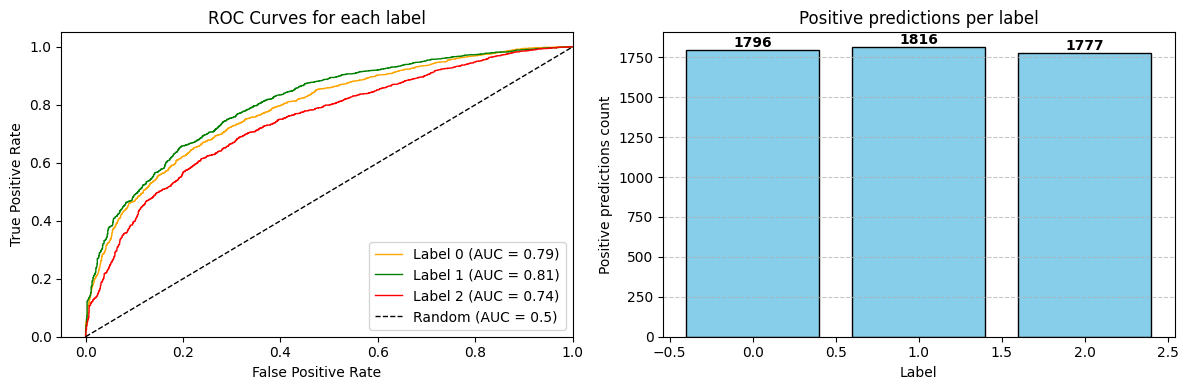

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5666174292564392
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5666174292564392}]

In [23]:
best_model_path = checkpoint_callback.best_model_path
seq_model= LitModel_Fluorescence_Clas.load_from_checkpoint(
    best_model_path,
    model = model, n_labels = out_channels,
    loss = nn.BCEWithLogitsLoss(),
    weight_decay = 1e-1, 
    lr = 1e-2, 
    print_each = 1)
     
trainer.test(seq_model, dataloaders = test_loader)